In [85]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from matplotlib.patches import Ellipse

In [92]:
image_path = './images/Cookie_theft_segmentation.png'
image = cv2.imread(image_path)

# Convert the image to RGB (OpenCV loads images in BGR format by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels
pixels = image_rgb.reshape(-1, 3)

# Use a KD-Tree to find unique colors within a threshold
threshold = 5
tree = cKDTree(pixels)
unique_colors = []
labels = np.zeros(pixels.shape[0], dtype=int) - 1

for i, pixel in enumerate(pixels):
    if labels[i] == -1:
        indices = tree.query_ball_point(pixel, threshold)
        unique_colors.append(pixel)
        labels[indices] = len(unique_colors) - 1

unique_colors = np.array(unique_colors)

# Print unique colors
print(f"Unique colors (within threshold): {unique_colors}")

Unique colors (within threshold): [[  0   0   0]
 [255   0   0]
 [  0   0 255]
 [128   0   0]
 [255 255   0]
 [  0 255 255]
 [128 128   0]
 [255   0 255]
 [  0   0 128]
 [  0 255   0]
 [  0 128   0]]


In [93]:
# Create a dictionary mapping from color tuples to segment labels
color_to_label = {tuple(color): label for label, color in enumerate(unique_colors)}

# Print the mapping
print(f"Color to label mapping: {color_to_label}")


Color to label mapping: {(0, 0, 0): 0, (255, 0, 0): 1, (0, 0, 255): 2, (128, 0, 0): 3, (255, 255, 0): 4, (0, 255, 255): 5, (128, 128, 0): 6, (255, 0, 255): 7, (0, 0, 128): 8, (0, 255, 0): 9, (0, 128, 0): 10}


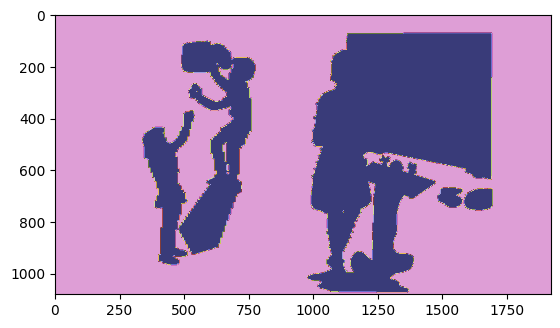

0


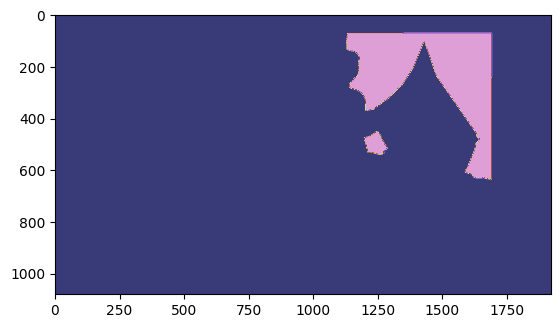

1


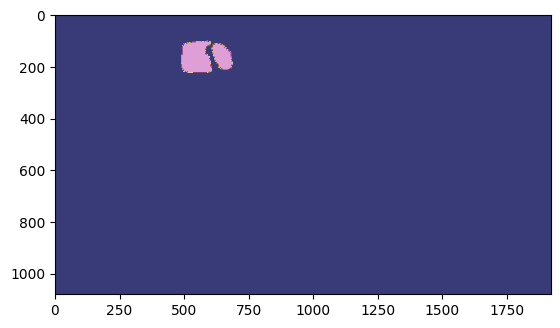

2


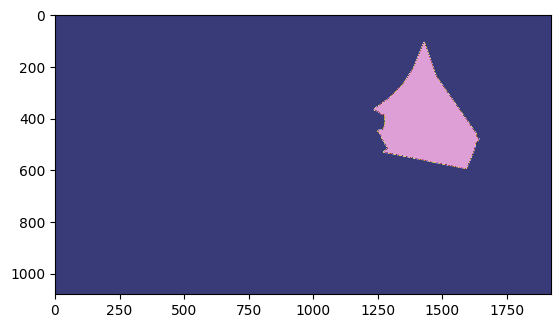

3


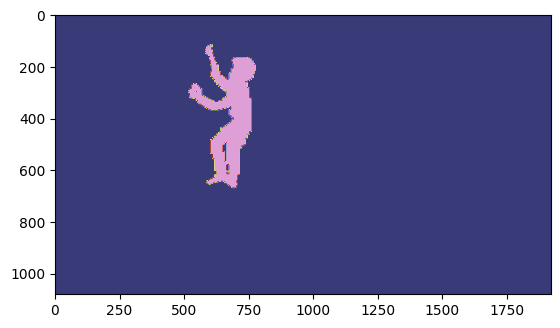

4


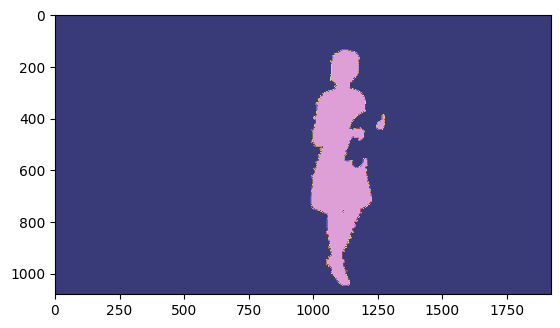

5


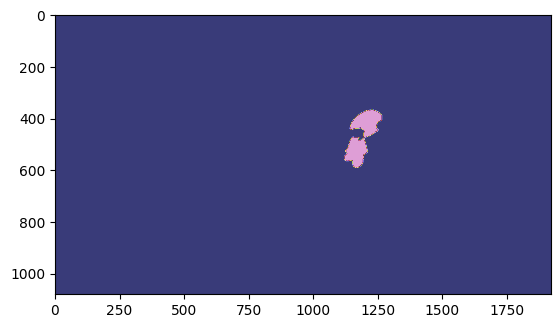

6


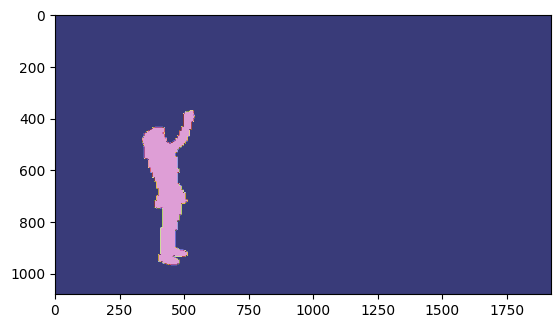

7


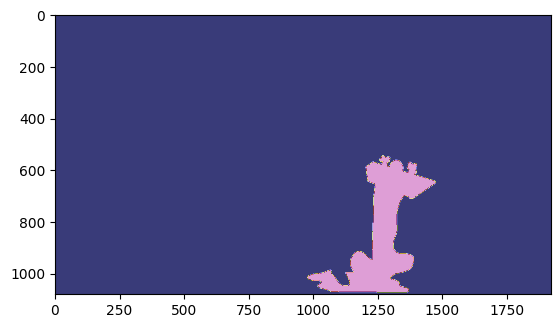

8


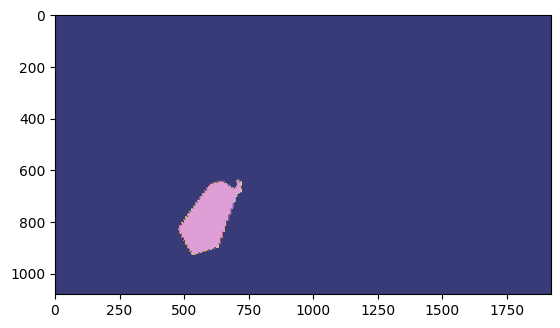

9


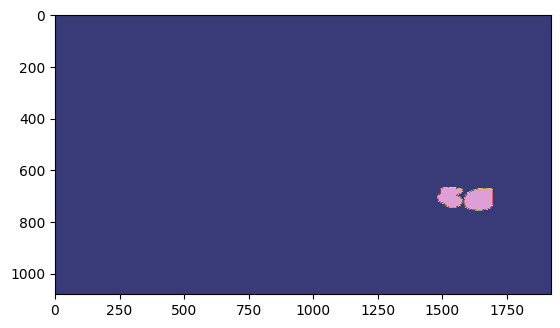

10
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [94]:
# Initialize the segmented mask with the same height and width as the input image
segmented_mask = np.zeros((image_rgb.shape[0], image_rgb.shape[1]), dtype=np.int32)

# Assign labels to each pixel based on the color
for i, color in enumerate(unique_colors):
    mask = np.all(image_rgb==color, axis=-1)
    plt.imshow(mask, cmap='tab20b')
    plt.show()
    print(i)
    segmented_mask[mask] = i

# Print the segmented mask
print(segmented_mask)


(959, 539, (0, 0, 0))
(645, 163, (255, 0, 0))
(543, 168, (255, 0, 0))
(1237, 500, (0, 0, 255))
(1459, 239, (0, 0, 255))
(1262, 841, (128, 0, 0))
(1258, 425, (255, 255, 0))
(1098, 564, (255, 255, 0))
(676, 400, (0, 255, 255))
(433, 653, (255, 0, 255))
(1435, 410, (0, 0, 128))
(594, 786, (0, 255, 0))
(1639, 715, (0, 128, 0))
(1527, 705, (0, 128, 0))
[(959, 539, (0, 0, 0)), (645, 163, (255, 0, 0)), (543, 168, (255, 0, 0)), (1237, 500, (0, 0, 255)), (1459, 239, (0, 0, 255)), (1262, 841, (128, 0, 0)), (1258, 425, (255, 255, 0)), (1098, 564, (255, 255, 0)), (676, 400, (0, 255, 255)), (433, 653, (255, 0, 255)), (1435, 410, (0, 0, 128)), (594, 786, (0, 255, 0)), (1639, 715, (0, 128, 0)), (1527, 705, (0, 128, 0))]
Centroid of color (0, 0, 0): (959, 539)
Centroid of color (255, 0, 0): (645, 163)
Centroid of color (255, 0, 0): (543, 168)
Centroid of color (0, 0, 255): (1237, 500)
Centroid of color (0, 0, 255): (1459, 239)
Centroid of color (128, 0, 0): (1262, 841)
Centroid of color (255, 255, 0):

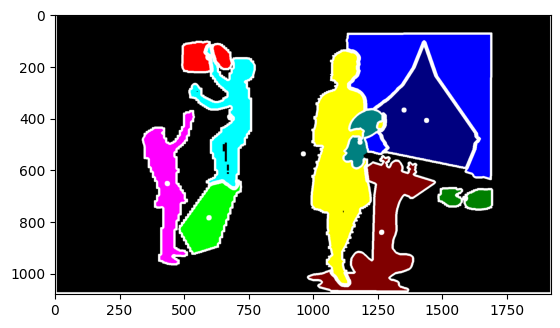

In [96]:
centroids = []
# Iterate over each unique color
for color in unique_colors:
    # Create a mask for the current color
    mask = cv2.inRange(image, color, color)
    
    # Find the contours of the masked region
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, (255,255,255), 5)
    # Compute the centroid of each contour
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY, tuple(color)))
        else:
            centroids.append((0, 0, tuple(color)))
        print(centroids[-1])

print(centroids)
post_processed_centroids = {}
# Print the centroids
for idx, (cX, cY, color) in enumerate(centroids):
    print(f"Centroid of color {color}: ({cX}, {cY})")
    if post_processed_centroids.get(color) is not None:
        post_processed_centroids[color][0] += cX
        post_processed_centroids[color][1] += cY
        post_processed_centroids[color][0] /= 2
        post_processed_centroids[color][1] /= 2
        post_processed_centroids[color][0] = round(post_processed_centroids[color][0])
        post_processed_centroids[color][1] = round(post_processed_centroids[color][1])
    else:
        post_processed_centroids[color] = [cX, cY]

centroids = []
for color in list(post_processed_centroids.keys()):
    centroids.append((post_processed_centroids[color][0], post_processed_centroids[color][1], color))


# Optionally, draw the centroids on the image for visualization
for (cX, cY, color) in centroids:
    print(cX, cY, color)
    cv2.circle(image, (cX, cY), 10, (255, 255, 255), -1)

plt.imshow(image)
plt.show()

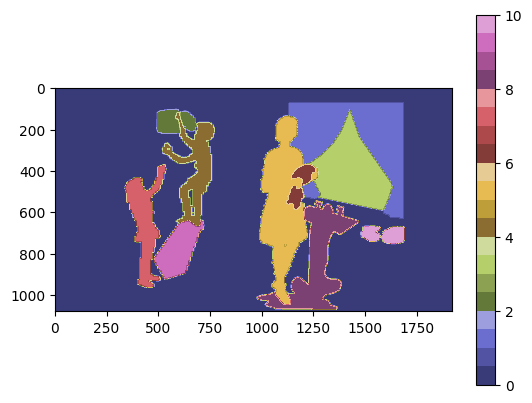

In [97]:
import matplotlib.pyplot as plt

plt.imshow(segmented_mask, cmap='tab20b')
plt.colorbar()
plt.show()


In [6]:
mask_id_list = np.unique(segmented_mask)
mask_id_list

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [98]:
image_component_id_lookup = {
    0: "Surrounding",
    1: "Curtain",
    2: "Cookie Jar",
    3: "Window",
    4: "Boy",
    5: "Lady",
    6: "Plate, Washing Cloth",
    7: "Girl",
    8: "Water, Sink",
    9: "Stool",
    10: "Dishes",
    11: "Image Components"
}
seperated_masks = {}

id: 0, tag: Surrounding
[-1  0]


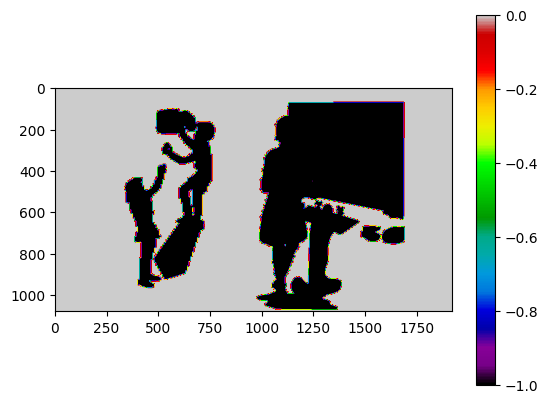

id: 1, tag: Curtain
[-1  1]


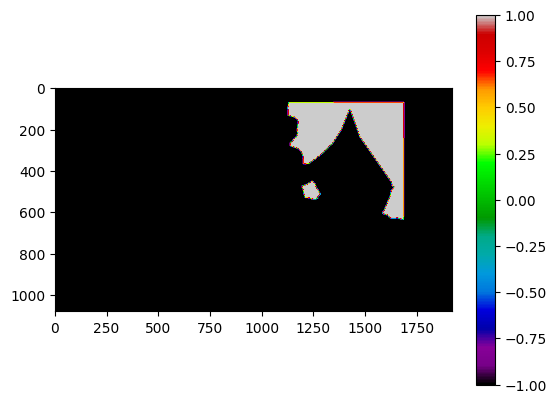

id: 2, tag: Cookie Jar
[-1  2]


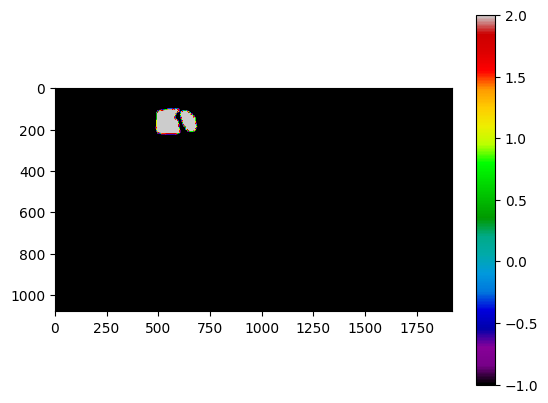

id: 3, tag: Window
[-1  3]


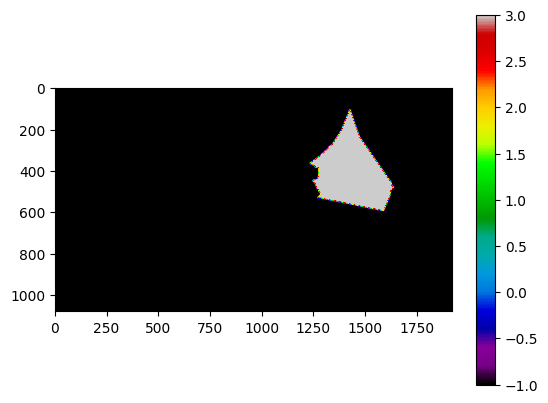

id: 4, tag: Boy
[-1  4]


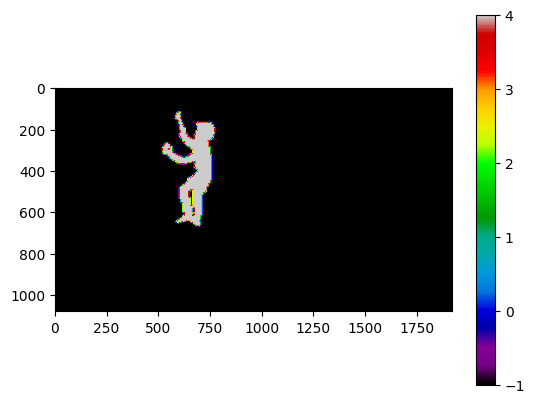

id: 5, tag: Lady
[-1  5]


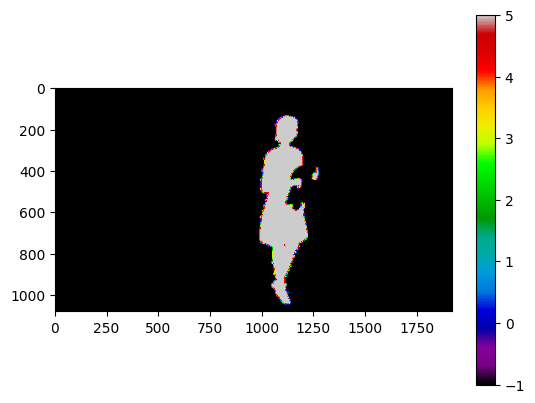

id: 6, tag: Plate, Washing Cloth
[-1  6]


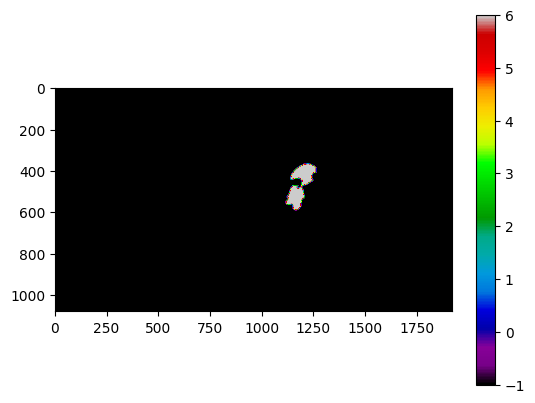

id: 7, tag: Girl
[-1  7]


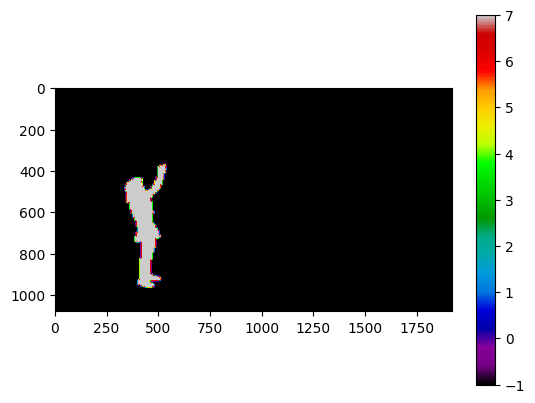

id: 8, tag: Water, Sink
[-1  8]


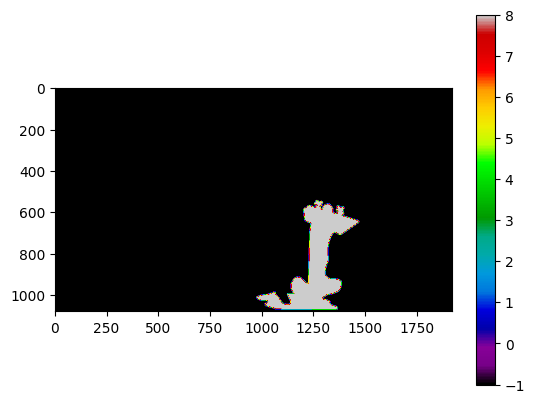

id: 9, tag: Stool
[-1  9]


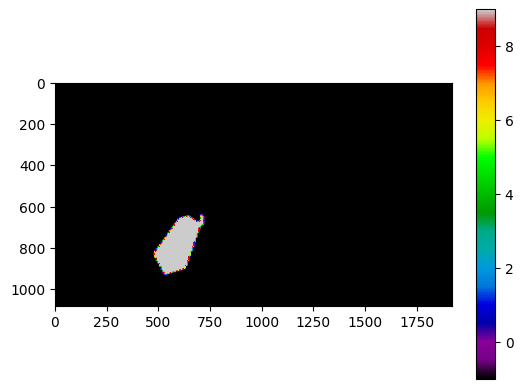

id: 10, tag: Dishes
[-1 10]


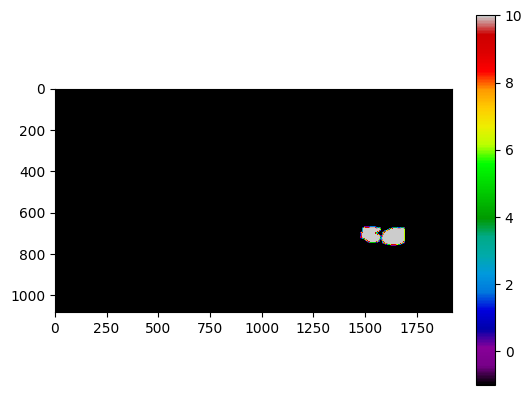

In [99]:
for id in mask_id_list:
    isolated_mask = segmented_mask.copy()
    isolated_mask[isolated_mask != id] = -1
    print(f"id: {id}, tag: {image_component_id_lookup[id]}")
    print(np.unique(isolated_mask))
    seperated_masks[id] = isolated_mask
    plt.imshow(seperated_masks[id], cmap='nipy_spectral')
    plt.colorbar()
    plt.show()

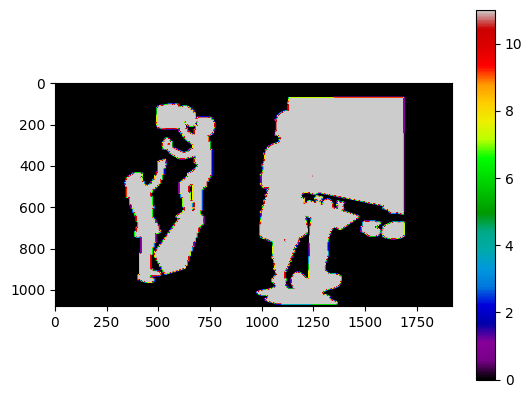

In [9]:
image_component_mask = segmented_mask.copy()
image_component_mask[image_component_mask != 0] = len(image_component_id_lookup) - 1
seperated_masks[len(image_component_id_lookup) - 1] = image_component_mask 
plt.imshow(seperated_masks[len(image_component_id_lookup) - 1], cmap='nipy_spectral')
plt.colorbar()
plt.show()

In [13]:
def get_pixel_coordinates(segmented_mask, label):
    # print(np.column_stack(np.where(segmented_mask == label)))
    image_component_mask = segmented_mask.copy()
    image_component_mask[image_component_mask != label] = -1
    plt.imshow(image_component_mask, cmap='nipy_spectral')
    print(np.unique(segmented_mask))
    print(np.unique(image_component_mask))
    plt.show()
    return np.column_stack(np.where(segmented_mask == label))

def fit_gmm_to_component(coordinates, n_components):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    gmm.fit(coordinates)
    return gmm

def compute_likelihoods(gmm, coordinates):
    return gmm.score_samples(coordinates)

Searching: 1 - Curtain
[-1  1]
[-1  1]


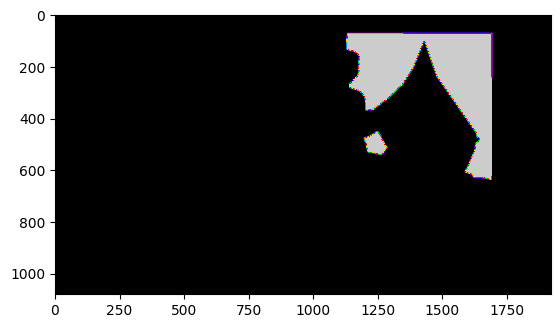

Best parameters: {'covariance_type': 'spherical', 'n_components': 1}
Searching: 2 - Cookie Jar
[-1  2]
[-1  2]


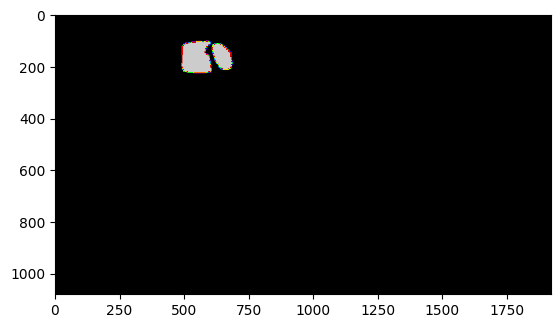

Best parameters: {'covariance_type': 'spherical', 'n_components': 1}
Searching: 3 - Window
[-1  3]
[-1  3]


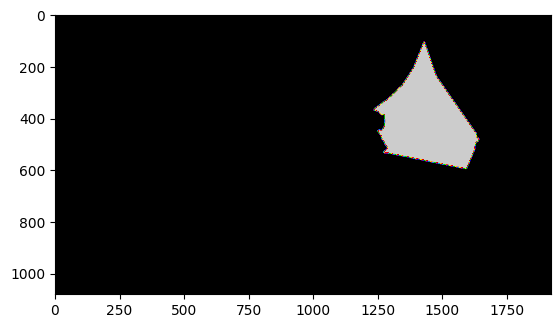

Best parameters: {'covariance_type': 'spherical', 'n_components': 1}
Searching: 4 - Boy
[-1  4]
[-1  4]


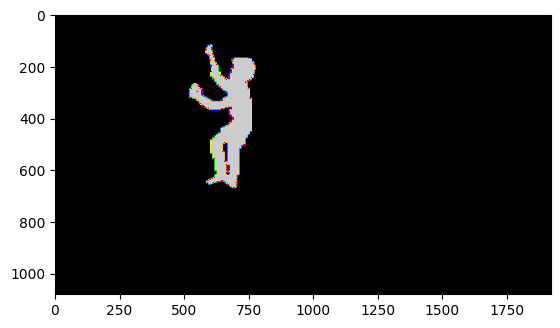

Best parameters: {'covariance_type': 'diag', 'n_components': 1}
Searching: 5 - Lady
[-1  5]
[-1  5]


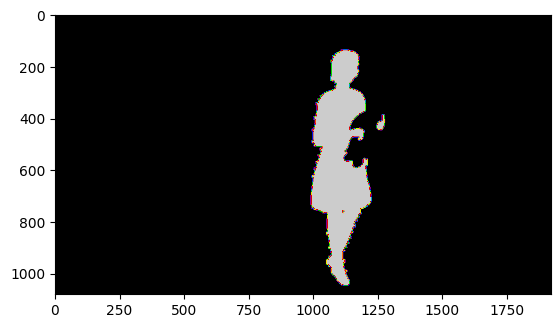

Best parameters: {'covariance_type': 'diag', 'n_components': 1}
Searching: 6 - Plate, Washing Cloth
[-1  6]
[-1  6]


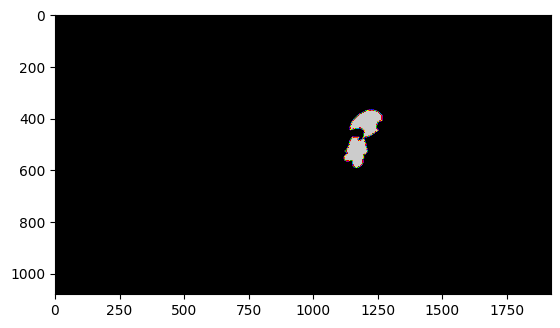

Best parameters: {'covariance_type': 'full', 'n_components': 1}
Searching: 7 - Girl
[-1  7]
[-1  7]


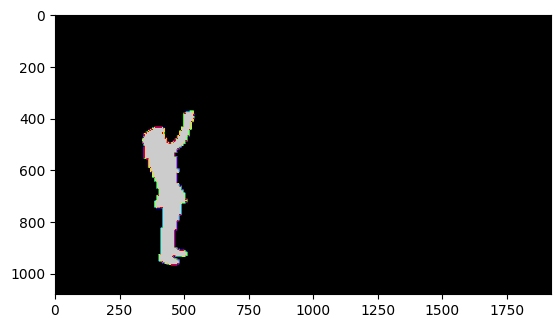

Best parameters: {'covariance_type': 'diag', 'n_components': 1}
Searching: 8 - Water, Sink
[-1  8]
[-1  8]


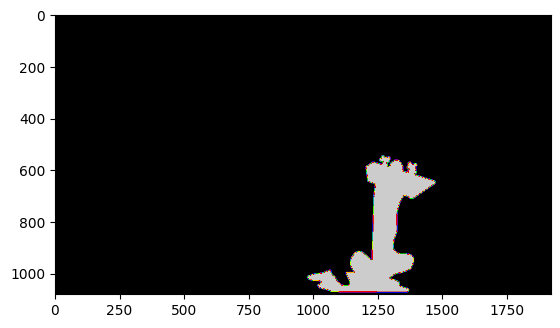

Best parameters: {'covariance_type': 'tied', 'n_components': 1}
Searching: 9 - Stool
[-1  9]
[-1  9]


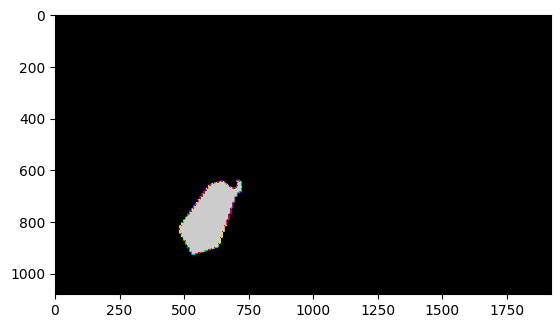

Best parameters: {'covariance_type': 'full', 'n_components': 1}
Searching: 10 - Dishes
[-1 10]
[-1 10]


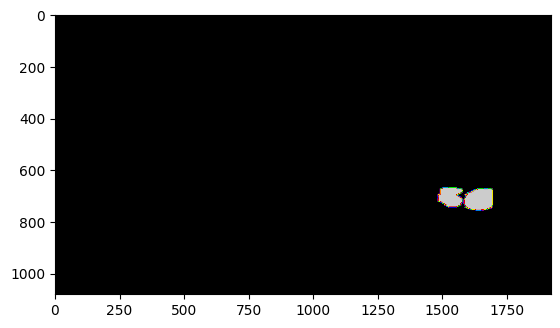

Best parameters: {'covariance_type': 'spherical', 'n_components': 2}
Searching: 11 - Image Components
[ 0 11]
[-1 11]


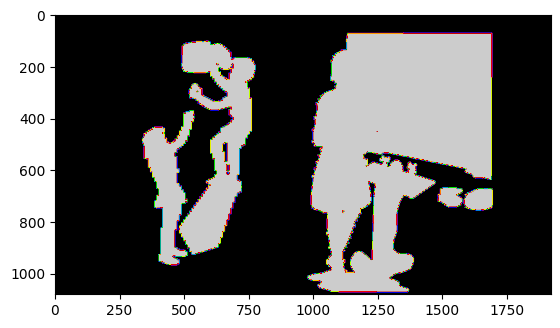

Best parameters: {'covariance_type': 'spherical', 'n_components': 1}


In [20]:
param_grid = {
    'n_components': range(1, 10),
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    # 'reg_covar': [1e-6, 1e-4, 1e-2, 1e-1]
}
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)
hyperparameters = {}
for key in list(image_component_id_lookup.keys()):
    if key == 0:
        continue
    print(f"Searching: {key} - {image_component_id_lookup[key]}")
    # Define the GMM model
    gmm = GaussianMixture(random_state=0)
    grid_search = GridSearchCV(
        gmm, param_grid=param_grid, scoring=gmm_bic_score
    )
    # Perform GridSearchCV
    component_coords = get_pixel_coordinates(seperated_masks[key], key)
    grid_search.fit(component_coords)

    # Best parameters
    best_params = grid_search.best_params_
    hyperparameters[key] = best_params

    print(f'Best parameters: {best_params}')

Fitting: 1 - Curtain
[-1  1]
[-1  1]


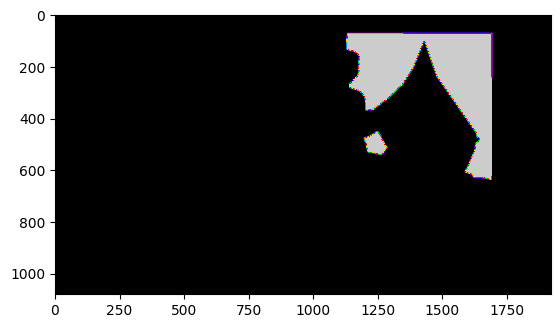

data: [[  73 1346]
 [  73 1347]
 [  73 1348]
 ...
 [ 638 1683]
 [ 638 1684]
 [ 638 1685]]
Fitting: 2 - Cookie Jar
[-1  2]
[-1  2]


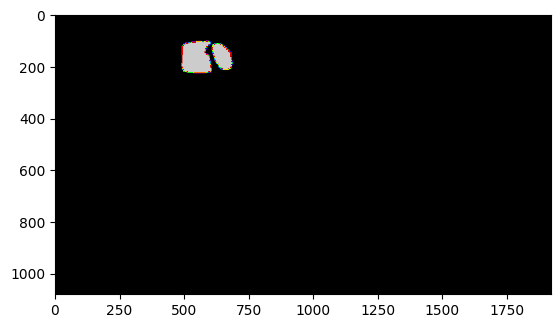

data: [[104 584]
 [104 585]
 [104 586]
 ...
 [226 581]
 [226 582]
 [226 583]]
Fitting: 3 - Window
[-1  3]
[-1  3]


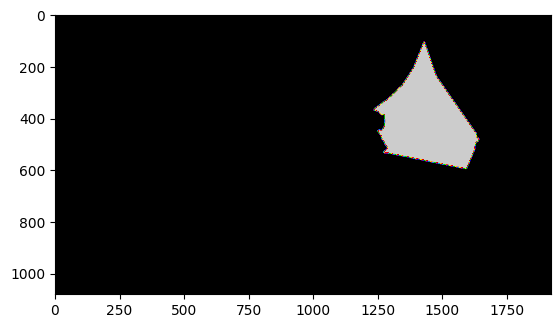

data: [[ 108 1424]
 [ 108 1425]
 [ 108 1426]
 ...
 [ 596 1587]
 [ 596 1588]
 [ 596 1589]]
Fitting: 4 - Boy
[-1  4]
[-1  4]


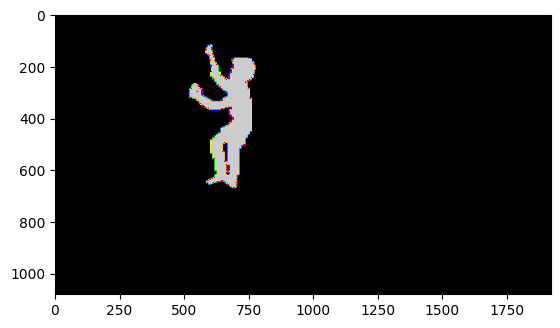

data: [[118 599]
 [118 600]
 [118 601]
 ...
 [670 694]
 [670 695]
 [670 696]]
Fitting: 5 - Lady
[-1  5]
[-1  5]


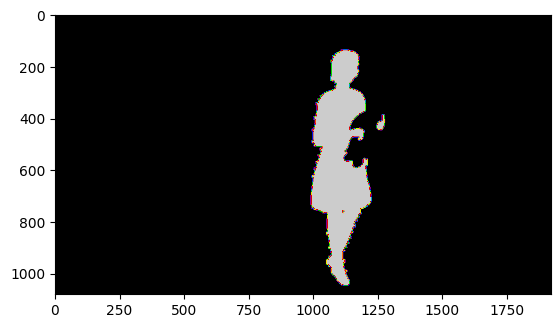

data: [[ 138 1112]
 [ 138 1113]
 [ 138 1114]
 ...
 [1046 1130]
 [1046 1131]
 [1046 1132]]
Fitting: 6 - Plate, Washing Cloth
[-1  6]
[-1  6]


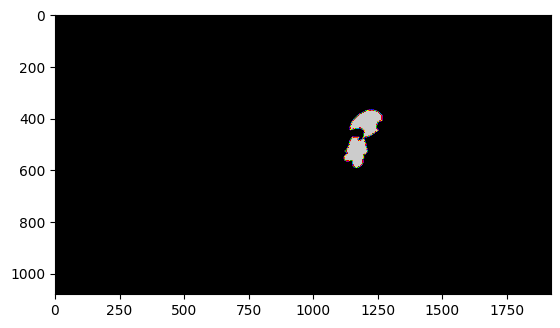

data: [[ 369 1223]
 [ 369 1224]
 [ 369 1225]
 ...
 [ 592 1165]
 [ 592 1166]
 [ 592 1167]]
Fitting: 7 - Girl
[-1  7]
[-1  7]


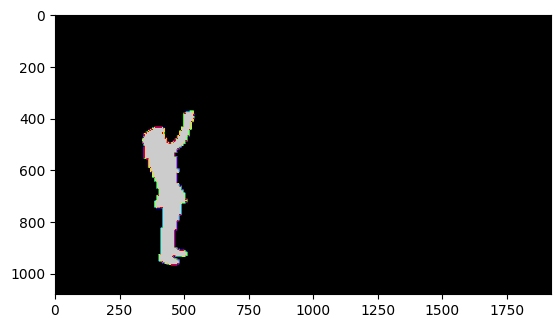

data: [[372 520]
 [372 521]
 [372 522]
 ...
 [967 469]
 [967 470]
 [967 471]]
Fitting: 8 - Water, Sink
[-1  8]
[-1  8]


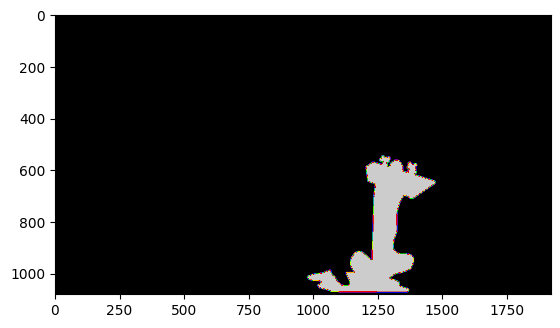

data: [[ 546 1264]
 [ 546 1265]
 [ 546 1266]
 ...
 [1072 1359]
 [1072 1360]
 [1072 1361]]
Fitting: 9 - Stool
[-1  9]
[-1  9]


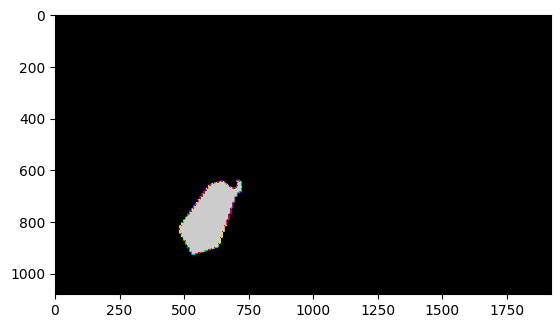

data: [[640 703]
 [640 704]
 [640 705]
 ...
 [926 541]
 [926 542]
 [926 543]]
Fitting: 10 - Dishes
[-1 10]
[-1 10]


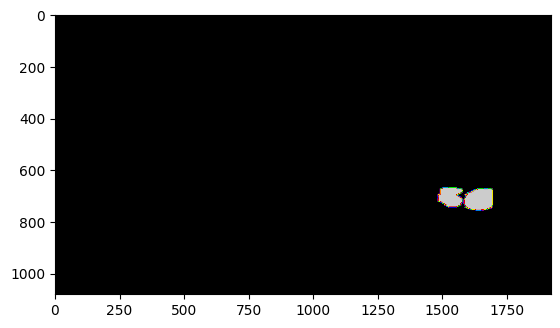

data: [[ 669 1520]
 [ 669 1521]
 [ 669 1522]
 ...
 [ 756 1645]
 [ 756 1646]
 [ 756 1647]]


In [23]:
component_gmms = {}
gmm_means = []
gmm_covariances = []
gmm_weights = []
for key in list(image_component_id_lookup.keys()):
    if key == 0 or key == len(image_component_id_lookup) - 1:
        continue
    print(f"Fitting: {key} - {image_component_id_lookup[key]}")
    component_coords = get_pixel_coordinates(seperated_masks[key], key)
    print(f"data: {component_coords}")
    gmm = fit_gmm_to_component(component_coords, hyperparameters[key]["n_components"])
    gmm_means.append(gmm.means_)
    gmm_covariances.append(gmm.covariances_)
    gmm_weights.append(gmm.weights_)
    component_gmms[image_component_id_lookup[key]] = gmm

In [45]:
combined_means = np.vstack(gmm_means)
combined_covariances = np.vstack(gmm_covariances)
combined_weights = np.hstack(gmm_weights)
combined_weights /= np.sum(combined_weights)

combined_gmm = GaussianMixture(n_components=len(combined_means), covariance_type='full')
combined_gmm.means_ = combined_means
combined_gmm.covariances_ = combined_covariances
combined_gmm.weights_ = combined_weights
combined_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(combined_covariances)).transpose((0, 2, 1))

component_gmms[len(image_component_id_lookup) - 1] = combined_gmm

GaussianMixture(n_components=11)


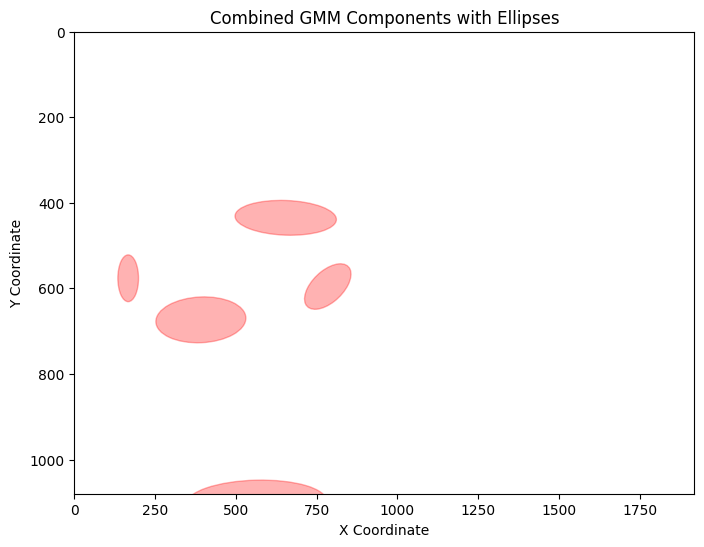

In [47]:
# Function to draw an ellipse representing a Gaussian component
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    ellipse = Ellipse(position, width, height, angle=angle, **kwargs)
    ax.add_patch(ellipse)

# Assuming combined_gmm is already defined and has the necessary attributes
# Example of how combined_gmm might be structured:
# combined_gmm = {
#     'n_components': 3,
#     'means_': np.array([[0, 0], [2, 2], [-2, -2]]),
#     'covariances_': np.array([[[1, 0.5], [0.5, 1]], [[1, 0], [0, 1]], [[0.5, 0], [0, 0.5]]])
# }

# Plot the combined GMM
plt.figure(figsize=(8, 6))
print(combined_gmm)
for i in range(combined_gmm.n_components):
    mean = combined_gmm.means_[i]
    cov = combined_gmm.covariances_[i]
    draw_ellipse(mean, cov, alpha=0.3, color='red')

# for i in range(combined_gmm['n_components']):
#     mean = combined_gmm['means_'][i]
#     cov = combined_gmm['covariances_'][i]
#     draw_ellipse(mean, cov, alpha=0.3, color='red')

x_max = 1920
y_max = 1080


plt.title('Combined GMM Components with Ellipses')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(0, x_max)
plt.ylim(0, y_max)
plt.gca().invert_yaxis()  # Invert Y axis to match image coordinates
plt.show()
